In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [2]:
train = pd.read_csv("../data/drugsComTrain_raw.tsv", delimiter='\t')
train = train.rename(columns = {"Unnamed: 0": "uniqueID"})
train['date'] = pd.to_datetime(train['date'])

In [3]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


In [4]:
train.review[98]

'"I&#039;m 30 years old.  I started having really bad skin about 2 years ago from maybe stress in my life.  But, I tried EVERYTHING to get rid of it and it just got worse.  I finally went to a dermatologist and she put me on spironolactone.  My skin started getting better in about two weeks. I LOVED it. I&#039;ve been taking it for about 6 months and I get compliments from Makeup artist and models (I&#039;m a hairstylist) about how good my skin is.  Another plus for me is my breasts went from a small B to a C! I decided to stop taking it for a week and my breasts went small again and my skin is getting a little oily. So I&#039;m going back on. I only take one a day."'

In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [6]:
train['review'] = train['review'].apply(clean_text)

In [7]:
train.review[98]

'i#039 30 years old started really bad skin 2 years ago maybe stress life tried everything get rid got worse finally went dermatologist put spironolactone skin started getting better two weeks loved i#039 taking 6 months get compliments makeup artist models i#039 hairstylist good skin another plus breasts went small b c decided stop taking week breasts went small skin getting little oily i#039 going back take one day'

In [8]:
train['review_len'] = train['review'].apply(lambda x: len(x))

In [9]:
train['review_len'].describe()

count    161297.000000
mean        288.216290
std         154.187267
min           0.000000
25%         164.000000
50%         284.000000
75%         425.000000
max        6931.000000
Name: review_len, dtype: float64

In [10]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SpatialDropout1D, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 76713 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(train['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (161297, 500)


In [13]:
y = pd.get_dummies(train['rating']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (161297, 10)


In [14]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(96778, 500) (96778, 10)
(64519, 500) (64519, 10)


In [30]:
epochs = 10
batch_size = 64

In [39]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
   1/1361 [..............................] - ETA: 2:09:56 - loss: 2.3019 - accuracy: 0.1094

KeyboardInterrupt: 

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________


In [33]:
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2017/2017 [==============================] - 198s 98ms/step - loss: 1.6790 - accuracy: 0.4794
Test set
  Loss: 1.679
  Accuracy: 0.479


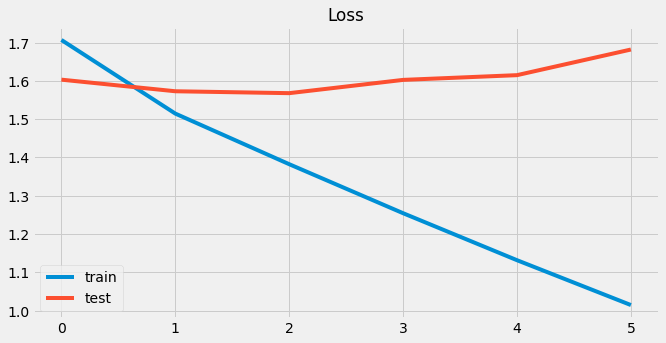

In [34]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

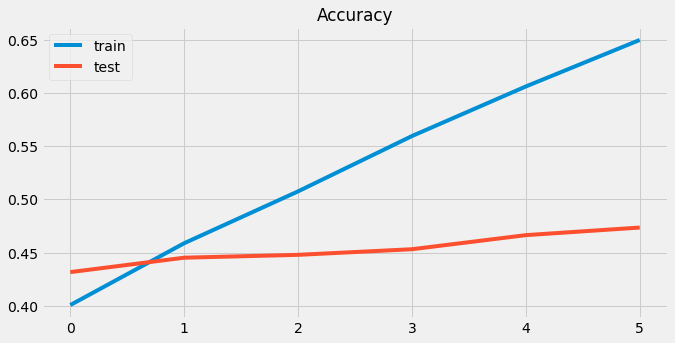

In [35]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [36]:
new_review = ['I have tried several different blood pressure meds. Valsartan gave me the worst side effects, dizziness, shakiness, nausea, headaches, sore muscles, and extreme fatigue! I would not recommend this drug to anyone. Actually raised my blood pressure.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(pred, labels[np.argmax(pred)])

[[9.0334255e-01 4.6970453e-02 1.2076531e-02 1.1933939e-02 1.0632593e-02
  5.3370045e-03 4.6387604e-03 7.3042628e-04 2.7974304e-03 1.5402701e-03]] 1


In [37]:
new_review2 = ['Works good on 160 mg. But I need to take bisoprolol for atrial fibrillation also.']
seq2 = tokenizer.texts_to_sequences(new_review2)
padded2 = pad_sequences(seq2, maxlen=MAX_SEQUENCE_LENGTH)
pred2 = model.predict(padded2)
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(pred2, labels[np.argmax(pred2)])

[[4.5233668e-05 1.0002806e-05 6.5694671e-06 1.0596431e-05 1.8687704e-05
  4.5925102e-05 1.6897987e-04 1.2601324e-03 4.1025747e-03 9.9433124e-01]] 10


In [ ]:
# start with smaller size
# try decreasing learning rate, or adding dropout layer to avoid overfitting
# build confusion matrix for each class
# try add one more layer
# try add weight to deal with imbalanced data